In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
import cv2
import pickle
import tqdm
import glob
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

In [30]:
df = pd.DataFrame.from_csv('./train.csv')

40479 pictures (shape : (256, 256, 3)) and 458 differents types in the training set


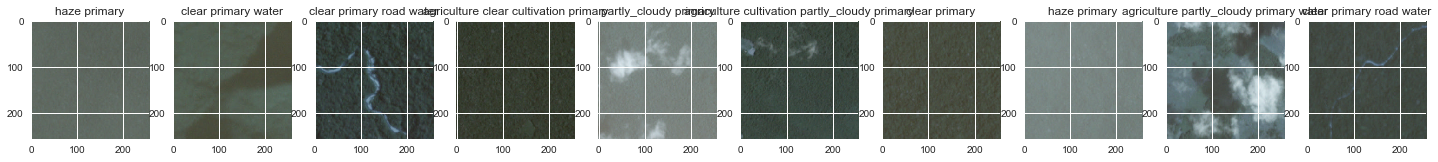

In [31]:
all_pictures = glob.glob('./train-jpg/*.jpg')
print('{} pictures (shape : {}) and {} differents types in the training set'.format(
                        len(all_pictures), cv2.imread(all_pictures[0]).shape, len(df.tags.unique())))
f, ax = plt.subplots(ncols=10, figsize=(25,30))
for i, k in enumerate(np.random.randint(len(df), size=10)):
    img = cv2.imread('./train-jpg/{}.jpg'.format(df.index[k]))
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[k]["tags"])

([<matplotlib.axis.XTick at 0x1178b8278>,
 <a list of 12 Text xticklabel objects>)

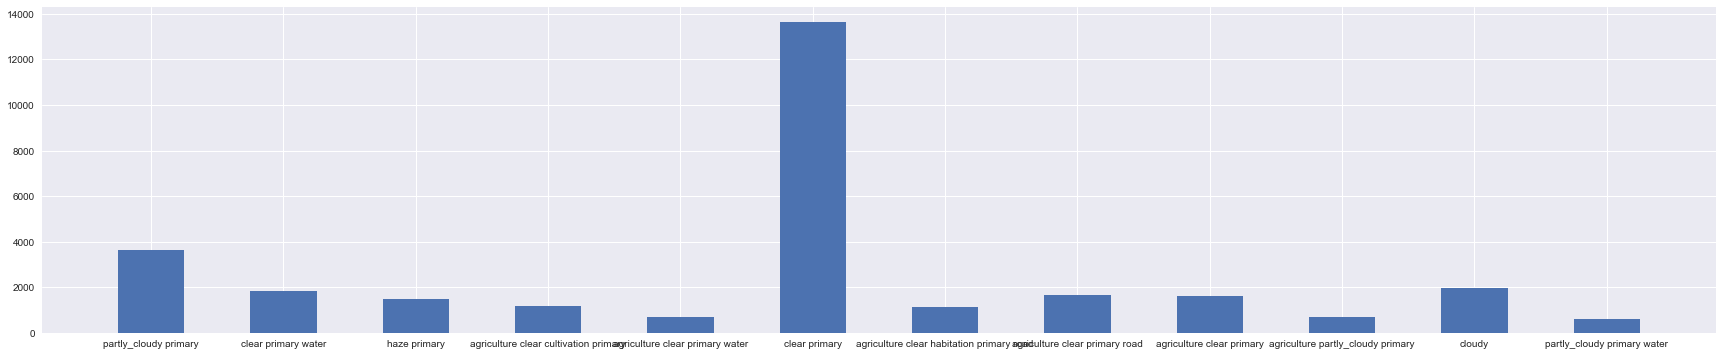

In [32]:
d = df['tags'].value_counts()[:12].to_dict()
plt.figure(figsize=(30,6))
plt.bar(range(len(d)), d.values(), width=0.5)
plt.xticks(range(len(d)), d.keys())

In [33]:
df2 = df[df.tags.isin(df['tags'].value_counts()[:15].index)]

In [108]:
mapping = dict(enumerate(df2.tags.unique()))
reverse_mapping = {v:k for k,v in mapping.items()}

In [95]:
picture_size = 28
pictures = []
labels = []
for pic in tqdm.tqdm(np.random.choice(df2.index, len(df2))):
    img = cv2.imread('./train-jpg/{}.jpg'.format(pic), 0) / 255.
    img = cv2.resize(img, (picture_size,picture_size))
    tag = df2.loc[pic].tags
    pictures.append(img)
    labels.append(reverse_mapping[tag])

100%|██████████| 31655/31655 [01:18<00:00, 402.85it/s]


In [96]:
pictures_train = pictures[:int(len(pictures)*0.8)]
labels_train = labels[:int(len(pictures)*0.8)]

pictures_valid = pictures[int(len(pictures)*0.8) : int(len(pictures)*0.9)]
labels_valid = labels[int(len(labels)*0.8) : int(len(labels)*0.9)]

pictures_test = pictures[int(len(pictures)*0.9):]
labels_test = labels[int(len(labels)*0.9):]

In [112]:
## With TensorFlow

import tensorflow as tf
batch_size = 50
num_steps = 30001

def reformat(dataset, labels):
    dataset = np.array(dataset).reshape((-1, picture_size, picture_size, 1)).astype(np.float32)
    labels = (np.arange(M) == np.array(labels)[:,None]).astype(np.float32).reshape(-1, M)
    return dataset, labels

train_dataset, train_labels = reformat(pictures_train, labels_train)
valid_dataset, valid_labels = reformat(pictures_valid, labels_valid)
test_dataset, test_labels = reformat(pictures_test, labels_test)

print('Train shape', train_dataset.shape, train_labels.shape)
print('Valid shape', valid_dataset.shape, valid_labels.shape)
print('Test shape', test_dataset.shape, test_labels.shape)
                          
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## Utility functions
def conv2d(x, W, stride=(1, 1), padding='SAME'):
    return tf.nn.conv2d(x, W, strides=[1, stride[0], stride[1], 1],
                      padding=padding)

def max_pool(x, ksize=(2, 2), stride=(2, 2)):
    return tf.nn.max_pool(x, ksize=[1, ksize[0], ksize[1], 1],
                        strides=[1, stride[0], stride[1], 1], padding='SAME')

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Graph
M = len(df.tags.unique())

graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32, shape=(batch_size, picture_size, picture_size, 1))
    y_ = tf.placeholder(tf.float32, shape=(batch_size, M))
    x_valid = tf.constant(valid_dataset, dtype=tf.float32)
    x_test = tf.constant(test_dataset, dtype=tf.float32)

    # Weights
    W_1 = weight_variable([5, 5, 1, 32])
    b_1 = bias_variable([32])
    W_2 = weight_variable([5, 5, 32, 64])
    b_2 = bias_variable([64])
    W_fc = weight_variable([int(picture_size / 4) * int(picture_size / 4) * 64, 1024])
    b_fc = bias_variable([1024])
    W_logits = weight_variable([1024, M])
    b_logits = bias_variable([M])

    def model(data):
        # First convolution
        h_conv1 = tf.nn.relu(conv2d(data, W_1) + b_1)
        h_pool1 = max_pool(h_conv1, ksize=(2, 2), stride=(2, 2))

        # Second convolution
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_2) + b_2)
        h_pool2 = max_pool(h_conv2, ksize=(2, 2), stride=(2, 2))
        # reshape tensor into a batch of vectors
        pool_flat = tf.reshape(h_pool2, [-1, int(picture_size / 4) * int(picture_size / 4) * 64])

        # Full connected layer with 1024 neurons.
        fc = tf.nn.relu(tf.matmul(pool_flat, W_fc) + b_fc)

        # Compute logits
        return tf.matmul(fc, W_logits) + b_logits

    logits = model(x)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_))
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
    y = tf.nn.softmax(logits)
    y_valid = tf.nn.softmax(model(x_valid))
    y_test = tf.nn.softmax(model(x_test))

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {x : batch_data, y_ : batch_labels}
        _, l, predictions = session.run([optimizer, loss, y], feed_dict=feed_dict)
        if (step % 1000 == 0):
                print('Minibatch loss at step %d: %f' % (step, l))
                print('Valid accuracy', accuracy(y_valid.eval(), valid_labels))
    print(accuracy(y_test.eval(), test_labels))

Train shape (25324, 28, 28, 1) (25324, 458)
Valid shape (3165, 28, 28, 1) (3165, 458)
Test shape (3166, 28, 28, 1) (3166, 458)
Minibatch loss at step 0: 10.999602
Valid accuracy 0.0
Minibatch loss at step 1000: 1.679750
Valid accuracy 57.2827804107
Minibatch loss at step 2000: 1.434237
Valid accuracy 58.420221169
Minibatch loss at step 3000: 1.485197
Valid accuracy 58.7677725118
Minibatch loss at step 4000: 1.163498
Valid accuracy 60.663507109
Minibatch loss at step 5000: 0.850928
Valid accuracy 62.2748815166
Minibatch loss at step 6000: 1.425967
Valid accuracy 63.317535545
Minibatch loss at step 7000: 1.169149
Valid accuracy 63.8862559242
Minibatch loss at step 8000: 1.192897
Valid accuracy 64.0126382306
Minibatch loss at step 9000: 1.088243
Valid accuracy 66.2875197472
Minibatch loss at step 10000: 0.957677
Valid accuracy 64.8657187994
Minibatch loss at step 11000: 1.005512
Valid accuracy 66.3507109005
Minibatch loss at step 12000: 0.719904
Valid accuracy 65.8451816746
Minibatch loss

In [114]:
## Test (learning on 14 classes) : 74.51 %
# Can try with a bigger picture size : 64 instead of 28